# Assignment 8: Neural Networks

Only use the already imported library `numpy` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`) and `matplotlib`. Make sure that the dataset `airfoil_self_noise.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

In [1]:
import numpy as np

def load_dataset(path):
    from sklearn.model_selection import train_test_split
    
    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    return X_train, X_test, y_train, y_test
    

X_train, X_test, y_train, y_test = load_dataset('airfoil_self_noise.csv')

## Task 3: Feedforward Neural Network: Programming

In this task, you will implement a feedforward neural network for regression. The hyperparameters of the model are:
- `input_dim`: The dimension of the input vector.
- `output_dim`: The dimension of the output vector.
- `width`: The dimension of each hidden layer.
- `depth`: The number of hidden layers. For B.Sc. Data Science students, this parameter is constant with a value of 1.
- `learning_rate`: The learning rate for gradient descent.
- `epochs`: The number of epochs/iterations performed during training.

B.Sc. Data Science only have to implement for a single hidden layer, i.e. `depth = 1`. All other students have to implement the network for any `depth >= 1`.

The activation function for each hidden layer is ReLU (g(x) = max(0, x)). The output layer uses the identity as activation, since our objective is regression.

You have to implement the `FeedforwardNeuralNetworkRegressor`.

The `__init__` method initializes the network.
Initialize each weight and bias randomly with a standard Gaussian distribution using the numpy function `numpy.random.normal` with default parameters.

The `fit` method trains the network.
Use backpropagation with gradient descent similar to Task 2.
Use the whole training data set for each training epoch.
Use the mean squared error as loss function.

The `predict` method computes the forward-pass of the network.

Evaluate your classifier on the test data with the mean squared error and compare your results to your linear regression model from assignment 3. Try out different hyper-parameters and compare the results. You may want to normalize your input and output data for better performance.

In [2]:
class FeedforwardNeuralNetworkRegressor(object):
    def __init__(self, input_dim, output_dim, width, depth, learning_rate, epochs):
        # Store all initialization parameters
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Create list for all weights and biases
        # Create a randomly initizalized weight and bias matrix for the input layer
        self.weights = [np.random.normal(size=(input_dim, width[0]))]
        self.biases = [np.random.normal(size=(width[0]))]
        # Create a randomly initizalized weight and bias matrix for each hidden layer
        for i in range(self.depth-1):
            self.weights.append(np.random.normal(size=(width[i], width[i+1])))
            self.biases.append(np.random.normal(size=(width[i+1])))
        # Create a randomly initizalized weight and bias matrix for the output layer
        self.weights.append(np.random.normal(size=(width[depth-1], output_dim)))
        self.biases.append(np.random.normal(size=(output_dim)))
        
    def fit(self, X, y):
        errors = np.zeros(self.epochs)
        current_ep = self.epochs-1
        for ep in range(self.epochs):
            self.hidden_z, self.hidden_x, pred = self.forward(X)
            errors[ep] = self.mse_loss(pred, y)
            if ep > 0 and (errors[ep-1]-errors[ep]) < 1e-5:
                current_ep = ep
                break
            biases_der, weights_der = self.backward(pred, y)
            for i in range(self.depth+1):
                self.biases[i] -= self.learning_rate * biases_der[self.depth-i]
                self.weights[i] -= self.learning_rate * weights_der[self.depth-i]
        return errors[:current_ep+1]
    
    def predict(self, X):
        # Run the forward pass and return the predicted output
        _, _, pred = self.forward(X)
        return pred
    
    
    def relu(self, layer):
        return np.maximum(0, layer)
    
    def relu_der(self, layer):
        return 1*(layer > 0)
    
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true)*(y_pred - y_true))
    
    def mse_loss_der(self, y_pred, y_true):
        return 2 * (y_pred - y_true)
    
    def forward(self, X):
        # Implementation of the forward pass
        # Store the intermediate results of the hidden layers for the back propagation
        hidden_x = [X]
        hidden_z = []
        for i in range(self.depth):
            hidden_z.append(hidden_x[i] @ self.weights[i] + self.biases[i])
            hidden_x.append(self.relu(hidden_z[i]))
        output = hidden_x[self.depth] @ self.weights[self.depth] + self.biases[self.depth]
        
        return hidden_z, hidden_x, output
    
    def backward(self, pred, y):
        # delta = intermediate loss derivatives
        delta = self.mse_loss_der(pred, y)
        biases_der = [np.mean(delta, axis=0)]
        weights_der = [(self.hidden_x[self.depth].T @ delta)/len(delta)]
        for i in range(self.depth, 0, -1):
            delta = delta @ self.weights[i].T
            relu_der_z = self.relu_der(self.hidden_z[i-1])
            delta = np.multiply(delta, relu_der_z)
            biases_der.append(np.mean(delta, axis=0))
            weights_der.append((self.hidden_x[i-1].T @ delta)/len(delta))
            
        return biases_der, weights_der


In [3]:
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

def normalizeData(data, minData, maxData):
    return (data - minData)/(maxData - minData)

Xmin = X_train.min(axis=0)
Xmax = X_train.max(axis=0)
Ymin = y_train.min(axis=0)
Ymax = y_train.max(axis=0)

X_train = normalizeData(X_train, Xmin, Xmax)
X_test = normalizeData(X_test, Xmin, Xmax)
y_train = normalizeData(y_train, Ymin, Ymax)
y_test = normalizeData(y_test, Ymin, Ymax)

Final training error ( Epoch 100 ): 0.018327899799292096
Test error: 0.017410832028141643


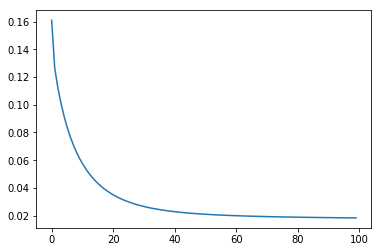

In [5]:
# Implement your training and evaluation here.
import matplotlib.pyplot as plt

np.random.seed(2020)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
myNN = FeedforwardNeuralNetworkRegressor(input_dim, output_dim, [5], 1, 0.1, 100)
train_error = myNN.fit(X_train, y_train)
print("Final training error ( Epoch", len(train_error), "):", train_error[len(train_error)-1])

y_pred = myNN.predict(X_test)
test_error = myNN.mse_loss(y_pred, y_test)
print("Test error:", test_error)

plt.figure()
plt.plot(train_error)
plt.show()